# Last.fm Fun

## Contents
- [1 Introduction](#1-Introduction)
- [2 Imports and Setups](#2-Imports-and-Setups)
- [3 Functions](#3-Functions)
  - [3.1 Last.fm Calls](#3.1-Last.fm-Calls)
  - [3.2 Processing](#3.2-Processing)
- [4 Data Loading and Retrieval](#4-Data-Loading-and-Retrieval)
  - [4.1 Datetime Conversion](#4.1-Datetime-Conversion)
- [5 User Data Analysis](#5-User-Data-Analysis)
  - [5.1 Top Five](#5.1-Top-Five)
- [6 Totals and Averages](#6-Totals-and-Averages)
- [7 Charts](#7-Charts)
  - [7.1 Daily Listening](#7.1-Daily-Listening)
  - [7.2 Monthly Listening](#7.2-Monthly-Listening)
  - [7.3 Weekly Listening](#7.3-Weekly-Listening)
  - [7.4 Hourly Listening](#7.4-Hourly-Listening)
  - [7.5 Charts for Top 5 Artists, Albums, and Tracks](#7.5-Charts-for-Top-5-Artists,-Albums,-and-Tracks)
- [8 Save Data](#8-Save-Data)

## 1 Introduction

It's the end of the year, and a lot of my friends were sharing their [Spotify wrapped](https://www.spotify.com/us/wrapped/) a few weeks ago, which is like a year-end review of a person's music listening. As a person who rarely uses Spotify, mine was shallow and not descriptive. For at least the past few years, Spotify has released their wrapped stats around the beginning of December, and I would patiently wait for Last.fm to give me mine, only for it to be released a couple of months into the next year, when no one else really cared to share or compare their stats. To fix this, I took on a small personal side project of making my own "wrapped" stats using Last.fm.

Querying the Last.fm was simple enough (albeit slow at times). Expectedly, most of my time with my project was spent cleaning and pruning. Last.fm seems to depend a lot on crowdsourced information, so it does come out quite messy, and even my user profile was messy because the sources of my scrobbles varied because I listen from YouTube, Bandcamp, Spotify, my own library, and so on. As I went through cleaning the song metadata from many sources, I found that Spotify scrobbles tended to feel particularly messy and inconsistent.

For my Last.fm wrapped, I took inspiration from both Spotify wrapped and Last.fm's yearly report, so most of the stats are just the usual stuff you'd see. I pulled out the top five artists, albums, and tracks. For basic numeric measures, there are the total scrobbles count, total seconds listened (in seconds and also converted to dd hh mm ss), the percentage of the whole year spent with music, the average track length in seconds (and in minutes with seconds), the average scrobbles per day and per month, and the longest streak (defined as consecutive days of scrobbles).

I played with a few charts, and most of them felt somewhat underwhelming, but it was fun to make and try at least. There are daily, monthly, weekly, and hourly listening charts, and I made some charts for the top five artists, albums, and tracks. The latter ones were extremely underwhelming. I would have liked more generic data because I think artists, albums, and tracks are a bit too granular, but alas, the genre tags from the Last.fm API are too messy, inconsistent, and (mostly) nonexistent. This is not saying Last.fm is bad, since its main function is not a song database, so perhaps some other resource would do this job better.

## 2 Imports and Setups

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from dataclasses import dataclass
import requests
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pytz
from tqdm import tqdm
from json.decoder import JSONDecodeError

In [2]:
load_dotenv(find_dotenv())
@dataclass(frozen=True)
class APIkeys:
    lfAPI: str = os.getenv('lfAPI')
    lfSecret: str = os.getenv('lfSecret')

In [3]:
USER_AGENT = "Synnefun"
API_KEY = APIkeys.lfAPI
THIS_YEAR = 2023
THIS_USER = "Synnu"
THIS_USER_TZ = 'America/Los_Angeles'

I took or adopted a couple of methods for querying Last.fm's API from [here](https://www.dataquest.io/blog/last-fm-api-python/).

## 3 Functions

### 3.1 Last.fm Calls

In [4]:
def lastfm_get(payload):
    """
    Returns the response of a GET request using the Last.fm API URL, a header,
    and a payload containing useful parameters.

    payload - A dictionary that must at least contain the get method to use.
    """
    # Define headers and URL
    headers = {
        'user-agent': USER_AGENT
    }
    url = 'https://ws.audioscrobbler.com/2.0/'

    # Add API key and format to payload
    payload['api_key'] = API_KEY
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    return response

See [user.getRecentTracks](https://www.last.fm/api/show/user.getRecentTracks) and [track.getInfo](https://www.last.fm/api/show/track.getInfo) for more information about the get requests used in `lastfm_get_tracks_by_dates()` and `last_fm_get_tracks_info()`.

In [5]:
def lastfm_get_tracks_by_dates(user, page, start_date, end_date):
    """
    Returns the response from the get request using a payload dictionary with
    the method "user.getrecenttracks". This queries the Last.fm API to attempt
    to retrieve recent tracks for the given user, from the start_date to the
    end_date, with a limit of 200 per page, starting from the page number
    indicated by the page argument.

    user - The username.
    page - The page number.
    start_date - The date to begin the query from as a UNIX timestamp.
    end_date - The date to end the query from as a UNIX timestamp.
    """
    if end_date > start_date:
        return lastfm_get({'method': 'user.getrecenttracks',
                           'user': user,
                           'limit': 200,
                           'page': page,
                           'from': int(start_date), 'to': int(end_date)})
    else:
        print("End date must be after the start date.")
        return None

In [6]:
def lastfm_recent_tracks_loop(user, date_start, date_end):
    """
    Returns the recent tracks for a user in the date window as a list if the
    response was successful. It will stop at the first occurrence of an error.

    user - The username.
    date_start - The date to begin the query from as a UNIX timestamp.
    date_end - The date to end the query from as a UNIX timestamp.
    """
    response_list = []
    # Need to get the furthest page because it fills from earliest to latest
    r = lastfm_get_tracks_by_dates(user, 1, date_start, date_end)
    page = int(r.json()['recenttracks']['@attr']['totalPages'])
    prog_bar = tqdm(desc='Requesting tracks', total=page)
    while (page >= 1):
        # Starting from furthest back
        # Call API
        response = lastfm_get_tracks_by_dates(user, page, date_start, date_end)
        
        # Stop if error
        if response.status_code != 200:
            print(response.text)
            break
        
        # Append response
        response_list.append(response)
        
        # Rest because querying too fast is bad
        # This is probably too generously slow
        time.sleep(0.5)
        
        page -= 1
        prog_bar.update(1)
    
    return response_list

Originally, I also added the option to use the mbid because I thought it would be more reliable than using the artist and song names, but a lot of the queries using the mbid returned nothing, and some of the mbid did not seem consistent.

I ran into an unexpected error exactly two times while running the looping query methods (`lastfm_recent_tracks_loop()` and `lastfm_get_tracks_info()`), but I have not been able to replicate any of them. One of them involved a `JSONDecodeError`, which is why there is a `try` statement below.

In [7]:
def lastfm_get_tracks_info(df):
    """
    Returns the information for a track. It will stop at the first occurrence of
    an error.

    df - A DataFrame containing artist_#text and name for the artist name and
         song name.
    """
    response_list = []
    prog_bar = tqdm(desc='Requesting track info', total=len(df))
    i = 0
    for index, row in df.iterrows():
        payload = {'method': 'track.getInfo'}
        # Only will query if the artist and song are not None/null
        if (row['artist_#text'] == row['artist_#text']) & (row['name'] == row['name']):
            # use artist and track name
            payload['artist'] = row['artist_#text']
            payload['track'] = row['name']
        # Call API
        response = lastfm_get(payload)
        if response.status_code != 200:
            print(response.text)
            break
        # Append response if track was found
        try:
            if 'track' in response.json().keys():
                response_list.append(response)
        except JSONDecodeError:
            print(response)
            print(response.status_code)
            print(response.text)
        # Rest...
        time.sleep(0.25)
        prog_bar.update(1)
    return response_list

### 3.2 Processing

In [8]:
def process_recent_tracks(responses):
    """
    Given a list of Last.fm user.getRecentTracks responses, returns a DataFrame
    of tracks (scrobbles). It will pull drop the "currently playing" track,
    which is always contained in a response; its existence is indicated by the
    existence of the '@attr' key.

    responses - A list of responses from a user.getRecentTrack call.
    """
    frames = [pd.DataFrame(r.json()['recenttracks']['track']) for r in responses]
    df = pd.concat(frames)
    if '@attr' in df.columns:
        # User was listening to music at the time of query but we don't necessarily
        # want currently playing tracks because we want to build dataset from past
        # to present, in case updates are needed
        df = df.drop(df[~df['@attr'].isnull()].index).drop(columns=['@attr']).reset_index(drop=True)
    return df

In [9]:
def process_tracks_info(responses):
    """
    Given a list of Last.fm track.getInfo responses, returns a DataFrame of song
    information. It only saves the song name, duration, and artist name from the
    response.

    responses - A list of responses from a track.getInfo call.
    """
    frames = []
    for r in responses:
        track_dict = {}
        track_dict['name'] = r.json()['track']['name']
        # duration in seconds, converted from milliseconds
        track_dict['track_duration_sec'] = float(r.json()['track']['duration']) * 0.001
        track_dict['artist_#text'] = r.json()['track']['artist']['name']
        frames.append(track_dict)
    df = pd.DataFrame(frames)
    return df

In [10]:
def flatten_dict_cols(df):
    """
    Flattens the dictionaries in a DataFrame into their own columns and returns
    the new DataFrame. It is intended to be used only with user.getRecentTrack
    responses.

    df - The DataFrame that has dictionary columns to flatten. These must be
         named 'artist', 'album', and 'date'.
    """
    df = df.reset_index(drop=True)
    frames = []
    # Three values in the response contain dictionaries that need to be flattened
    dict_cols = ['artist', 'album', 'date']
    for col in dict_cols:
        if col in df.columns:
            # Flattens the dictionaries into normal columns
            dict_frame = pd.DataFrame(list(df[col].values))
            old_names = dict_frame.columns
            new_names = []
            # Generate new names for the columns
            for name in old_names:
                new_names.append(col + "_" + name)
            dict_frame.rename(columns=dict(zip(old_names, new_names)), inplace=True)
            frames.append(dict_frame)
    # Remove the old columns that contain dicts
    pruned = df.drop(columns=dict_cols)
    if len(frames) != 0:
        # Concatenate the pruned and flattened frames
        combined_frames = pd.concat(frames, axis=1)
        return pd.concat([combined_frames, pruned], axis=1)
    else:
        return pruned

In [11]:
def format_recent_tracks_df(df):
    """
    Returns a DataFrame, with 'streamable', 'image', and 'url' removed, and with
    'mbid' renamed to 'song_mbid'. Then it calls `flatten_dict_cols()` to
    flatten the columns that contain dictionaries. This is meant to be used on
    the responses provided by a user.getRecentTrack call.

    df - The DataFrame created from a user.getRecentTrack call.
    """
    filtered_df = df.drop(columns=['streamable', 'image', 'url'])
    filtered_df.rename(columns={'mbid': 'song_mbid'}, inplace=True)
    filtered_df = flatten_dict_cols(filtered_df)
    return filtered_df

In an attempt to not build a user profile of tracks from scratch every time, I save the user's tracks from the year. This means that if it is updated or written out of order, then it will not update tracks listened to at an earlier time than that. The `lastfm_recent_tracks_loop()` starts from the beginning and goes forward. It makes sense to do it chronologically anyway because the user might listen to more songs in the year if the year is the current year.

I don't know how best to deal with timezones, but the 12/31 23\:59\:59 in UTC is the earliest second before the new year. Meanwhile, 1/2, the full day after 1/1, should grant the flexibility to prune the data as desired.

In [12]:
def update_user_profile(user, year):
    """
    Attempts to update or create an Excel file corresponding to the given
    username and year.
    
    user - The username.
    year - The year.
    """
    # Get window for year
    year_start = datetime.datetime(year - 1, 12, 31, hour=23, minute=59, second=59, tzinfo=pytz.timezone('UTC')).timestamp()
    # Extra day after because of timezones
    year_end = datetime.datetime(year + 1, 1, 2, hour=0, minute=0, second=0, tzinfo=pytz.timezone('UTC')).timestamp()
    # Make filename
    path = "profiles/" + user + "-" + str(year) + ".xlsx"
    
    if os.path.isfile(path):
        # A file has already been created for this user
        print("{} file found for {}.".format(user, year))
        print("Checking for updates.")
        # Read in the file
        df = pd.read_excel(path)
        # Get the latest date found in the Excel
        latest_date = df['date_uts'].max()
        if latest_date < year_end:
            # Query using last_date
            responses = lastfm_recent_tracks_loop(user, latest_date, year_end)
            # Process and append to DF
            new_tracks = process_recent_tracks(responses)
            new_tracks = format_recent_tracks_df(new_tracks)
            df = pd.concat([df, new_tracks])
    else:
        # A file has not been created for this user
        print("{} file not found for {}.".format(user, year))
        print("Attempting to build.")
        # Query using year window
        responses = lastfm_recent_tracks_loop(user, year_start, year_end)
        # Process and make DF
        df = process_recent_tracks(responses)
        df = format_recent_tracks_df(df)
    df['date_uts'] = df['date_uts'].astype('float64')
    df.sort_values(by='date_uts', inplace=True)
    # Save the updated/created DataFrame to path
    df.to_excel(path, index=False)

In [13]:
def get_user_profile(user, year):
    """
    Returns a DataFrame read from the user's profile for a year, which should
    have been saved as an Excel in the "profiles" directory. Returns None if the
    profile has not been created.

    user - The username for the profile to retrieve.
    year - The year of the profile to retrieve.
    """
    path = "profiles/" + user + "-" + str(year) + ".xlsx"
    if os.path.isfile(path):
        return pd.read_excel(path)
    else:
        return None

In [14]:
def combine_song_info(user_df, song_df):
    """
    Returns a DataFrame that is the left merge between the user_df and song_df,
    using the fully lowercased strings of artist name and song name.

    user_df - The user profile DataFrame.
    song_df - The song database DataFrame.
    """
    # Super simple text preprocessing
    user_df['artist_lower'] = user_df['artist_#text'].str.lower()
    user_df['song_lower'] = user_df['name'].str.lower()
    song_df['artist_lower'] = song_df['artist'].str.lower()
    song_df['song_lower'] = song_df['song_title'].str.lower()
    # Merge
    return user_df.merge(song_df, how="left", on=['artist_lower', 'song_lower'])

In [15]:
def lookup_track_info(df):
    """
    Returns track information given by the track.getInfo call.

    df - The DataFrame for which to look up songs and artists.
    """
    # Drop any duplicates so we don't query for the same artist and track
    no_reps = df.drop_duplicates(subset=['artist_#text', 'name'])
    # Since we are only going to save song durations from these queries, we only
    # look up songs that don't have a song_length
    tracks_info = process_tracks_info(
        lastfm_get_tracks_info(
            no_reps[no_reps['song_length'].isnull()][['artist_#text', 'name']]))
    # Only want the data if it actually yielded something useful
    # Originally it also returned some other stuff, but now it just looks up song duration
    return tracks_info[(tracks_info['track_duration_sec'] != 0)]

## 4 Data Loading and Retrieval

I called `update_user_profile()` to build or update the user's profile for the given year.

In [16]:
# Update/create user profile
update_user_profile(THIS_USER, THIS_YEAR)
print("User profile update completed.")

Synnu file found for 2023.
Checking for updates.


Requesting tracks: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


User profile update completed.


I loaded the user's profile for the given year as a DataFrame, which will be an .xlsx file with the name format of "<user>-<year>" saved in the "profiles" folder. In this example, it is "Synnu-2023" loaded into `synnu_df`.

I loaded the saved song data as a DataFrame `songs_df` and then combined the two DataFrames into a `user_song_df`.

In [17]:
# Read files
synnu_df = get_user_profile(THIS_USER, THIS_YEAR)
songs_df = pd.read_feather('songs.feather')
# Combine DataFrames
user_song_df = combine_song_info(synnu_df, songs_df)

In [18]:
user_song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11676 entries, 0 to 11675
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist_mbid   8502 non-null   object 
 1   artist_#text  11676 non-null  object 
 2   album_mbid    7029 non-null   object 
 3   album_#text   11349 non-null  object 
 4   date_uts      11676 non-null  int64  
 5   date_#text    11676 non-null  object 
 6   song_mbid     7703 non-null   object 
 7   name          11676 non-null  object 
 8   artist_lower  11676 non-null  object 
 9   song_lower    11676 non-null  object 
 10  artist        11185 non-null  object 
 11  song_title    11185 non-null  object 
 12  album         10752 non-null  object 
 13  song_length   11180 non-null  float64
dtypes: float64(1), int64(1), object(12)
memory usage: 1.2+ MB


In [19]:
user_song_df.head()

,artist_mbid,artist_#text,album_mbid,album_#text,date_uts,date_#text,song_mbid,name,artist_lower,song_lower,artist,song_title,album,song_length
0,82c770d1-8c62-4f4d-9021-7bd8a097f7dd,The Caretaker,01b991e1-66ef-4735-a7a0-61d07dc95cab,An Empty Bliss Beyond This World,1672546478,"01 Jan 2023, 04:14",dd2c1eef-4856-3144-8db7-b105b5f3183a,Libet's delay,the caretaker,libet's delay,The Caretaker,Libet's delay,An empty bliss beyond this world,206.520000
1,82c770d1-8c62-4f4d-9021-7bd8a097f7dd,The Caretaker,01b991e1-66ef-4735-a7a0-61d07dc95cab,An Empty Bliss Beyond This World,1672546685,"01 Jan 2023, 04:18",b5c3e6f9-3404-3dd7-a4a7-cadfd347475c,I feel as if I might be vanishing,the caretaker,i feel as if i might be vanishing,The Caretaker,I feel as if I might be vanishing,An empty bliss beyond this world,115.986667
2,82c770d1-8c62-4f4d-9021-7bd8a097f7dd,The Caretaker,01b991e1-66ef-4735-a7a0-61d07dc95cab,An Empty Bliss Beyond This World,1672546801,"01 Jan 2023, 04:20",0ba5e6ab-266b-38a2-b09c-9d1d4b2290e4,An empty bliss beyond this World,the caretaker,an empty bliss beyond this world,The Caretaker,An empty bliss beyond this World,An empty bliss beyond this world,259.640000
3,82c770d1-8c62-4f4d-9021-7bd8a097f7dd,The Caretaker,01b991e1-66ef-4735-a7a0-61d07dc95cab,An Empty Bliss Beyond This World,1672547060,"01 Jan 2023, 04:24",7ac23ef7-7e60-3eed-84f1-3431cd9f0e48,Bedded deep in long term memory,the caretaker,bedded deep in long term memory,The Caretaker,Bedded deep in long term memory,An empty bliss beyond this world,108.573333
4,82c770d1-8c62-4f4d-9021-7bd8a097f7dd,The Caretaker,01b991e1-66ef-4735-a7a0-61d07dc95cab,An Empty Bliss Beyond This World,1672547169,"01 Jan 2023, 04:26",4e054cfb-1270-312c-8c93-9fe9b320da90,A relationship with the sublime,the caretaker,a relationship with the sublime,The Caretaker,A relationship with the sublime,An empty bliss beyond this world,216.306667


This code below looks up the track info for the tracks that do not have filled 'song_length's using [track.getInfo](https://www.last.fm/api/show/track.getInfo). Currently, I'm only querying for missing 'song_length's. I would like to collect tags too, but doing so would basically require me to query the API for every song. For my user, that would mean potentially making 8000 or so queries, and that would take a really long time because I have to rate-limit my queries. I'm not sure how fruitful it would be to query the tags for every song anyway because from looking at it, most songs don't have tags, and many of the tags are not useful.

The code below updates my song database with LastFM queries...

### 4.1 Datetime Conversion

Although I could just use 'date_#text' to get the datetime using `user_song_df['date_#text'] = pd.to_datetime(user_song_df['date_#text'], utc=True, format="%d %b %Y, %H:%M")`, I found that the 'date_#text' provided by the Last.fm API is not accurate to the seconds. While I'm not sure if I will be using the seconds, I might as well retain the precision, which can be found when converting the UNIX/POSIX timestamp. Whether I am using the seconds or not, it is possible for more than one song to have been scrobbled in the same minute if the song durations permit.

In [20]:
user_song_df['date_time_utc'] = user_song_df['date_uts'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('UTC')))
user_song_df['date_time_utc'].dt.second.describe() # check that it looks better

count    11676.000000
mean        29.696814
std         17.272470
min          0.000000
25%         15.000000
50%         30.000000
75%         45.000000
max         59.000000
Name: date_time_utc, dtype: float64

In [21]:
# Select desired DF columns
us_df = user_song_df[['artist_#text', 'name', 'album_#text', 'album', 'song_length', 'date_uts', 'date_time_utc', 'artist_lower', 'song_lower']].copy()
us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11676 entries, 0 to 11675
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   artist_#text   11676 non-null  object             
 1   name           11676 non-null  object             
 2   album_#text    11349 non-null  object             
 3   album          10752 non-null  object             
 4   song_length    11180 non-null  float64            
 5   date_uts       11676 non-null  int64              
 6   date_time_utc  11676 non-null  datetime64[ns, UTC]
 7   artist_lower   11676 non-null  object             
 8   song_lower     11676 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(6)
memory usage: 821.1+ KB


In [22]:
# Fill 'album_#text' and drop 'album'. Rename columns
us_df = us_df \
    .fillna(value={'album_#text': us_df['album'], 'album': us_df['album_#text']}) \
    .drop(columns=['album']) \
    .rename(columns={'artist_#text': 'artist', 'album_#text': 'album', 'name': 'song'})
us_df['album_lower'] = us_df['album'].str.lower()
us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11676 entries, 0 to 11675
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   artist         11676 non-null  object             
 1   song           11676 non-null  object             
 2   album          11501 non-null  object             
 3   song_length    11180 non-null  float64            
 4   date_uts       11676 non-null  int64              
 5   date_time_utc  11676 non-null  datetime64[ns, UTC]
 6   artist_lower   11676 non-null  object             
 7   song_lower     11676 non-null  object             
 8   album_lower    11501 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(6)
memory usage: 821.1+ KB


In [23]:
# Changing to Pacific time because the current user in question, Synnu, is in Pacific time normally
us_df['date_time_usertz'] = us_df['date_time_utc'].dt.tz_convert(THIS_USER_TZ)
us_df = us_df[us_df['date_time_usertz'].dt.year == THIS_YEAR].copy()

In [24]:
# Note these are all in user tz
us_df['date_month'] = us_df['date_time_usertz'].dt.month
us_df['date_day'] = us_df['date_time_usertz'].dt.day
us_df['date_hour'] = us_df['date_time_usertz'].dt.hour
us_df['date_minute'] = us_df['date_time_usertz'].dt.minute
us_df['date_second'] = us_df['date_time_usertz'].dt.second

## 5 User Data Analysis

### 5.1 Top Five

In this section, there are tables of top five artists, albums, and tracks, by scrobble count and seconds listened.

#### 5.1.1 Artists

In [25]:
# Top Artist by Songs
us_df.groupby('artist_lower').size().to_frame('count').sort_values(by='count', ascending=False).head(5)

,count
artist_lower,
masayoshi soken,345
blind guardian,233
insomnium,217
two steps from hell,214
cicada,202


In [26]:
# Top Artist by Seconds
us_df.groupby('artist_lower')['song_length'].sum().to_frame('sec_listened').sort_values(by='sec_listened', ascending=False).head(5)

,sec_listened
artist_lower,
masayoshi soken,92964.490316
be'lakor,86511.482449
blind guardian,78058.531833
swallow the sun,76667.769458
insomnium,75564.616780


#### 5.1.2 Albums

In [27]:
# Top Album by Songs
us_df.groupby(['artist_lower', 'album_lower']).size().to_frame('count').sort_values(by='count', ascending=False).head(5)

,,count
artist_lower,album_lower,
cicada,棲​居​在​溪​源​之​上 seeking the sources of streams,154
谷岡久美,final fantasy crystal chronicles original soundtrack,115
paradise lost,icon,109
toby fox,undertale soundtrack,105
masayoshi soken,shadowbringers: final fantasy xiv original soundtrack,99


In [28]:
# Top Album by Seconds
us_df.groupby(['artist_lower', 'album_lower'])['song_length'].sum().to_frame('sec_listened').sort_values(by='sec_listened', ascending=False).head(5)

,,sec_listened
artist_lower,album_lower,
cicada,棲​居​在​溪​源​之​上 seeking the sources of streams,46569.126531
swallow the sun,"songs from the north i, ii & iii",31582.370975
insomnium,anno 1696,29716.413333
be'lakor,stone's reach,28117.280000
paradise lost,icon,26809.000000


#### 5.1.3 Tracks

In [29]:
# Top Songs
us_df.groupby(['artist_lower', 'song_lower']).size().to_frame('count').reset_index().sort_values(by='count', ascending=False).head(5)

,artist_lower,song_lower,count
1657,cicada,巨木曾在的痕跡 remains of ancient trees,32
1675,cicada,雨從傍晚下到午夜 raining on the tent,28
2365,didi han,what you love (feat. wansun kim),25
1041,blind guardian,imaginations from the other side,18
1664,cicada,松葉上的鳥與水珠 birds and moist pine needles,16


In [30]:
# Top Songs by Seconds
us_df.groupby(['artist_lower', 'song_lower'])['song_length'].sum().to_frame('sec_listened').reset_index().sort_values(by='sec_listened', ascending=False).head(5)

,artist_lower,song_lower,sec_listened
1657,cicada,巨木曾在的痕跡 remains of ancient trees,18402.625306
1665,cicada,棲居在溪源之上 seeking the sources of streams,10185.404082
1041,blind guardian,imaginations from the other side,9163.680000
2370,dieselboy,the 6ixth session disc 1,7689.146667
729,autechre,perlence subrange 6-36,7031.008617


### 6 Totals and Averages

This section has text outputs of the following:
 - Total scrobbles
 - Total seconds listened; and converted to days, hours, minutes, and seconds; and calculates the % of the whole year spent with music
 - Average track length in seconds, and converted to minutes and seconds
 - Average scrobbles per day; and per month
 - Longest streak (consecutive days) listening to music

In [31]:
# Total Scrobbles
total_scrobbles = us_df.shape[0]
print("Total tracks scrobbled: {:,d}".format(total_scrobbles))

Total tracks scrobbled: 11,652


In [32]:
def sec_to_dhms(seconds):
    """
    Converts seconds into days, hours, minutes, and seconds.

    seconds - The seconds to convert.
    """
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    d, h = divmod(h, 24)
    return d, h, m, s

# Total Listening Time
total_sec_listened = us_df['song_length'].sum()
d, h, m, s = sec_to_dhms(total_sec_listened)
print("Total seconds listened: {:.2f}\n{} days, {} hours, {} minutes, and {} seconds".format(total_sec_listened,
                                                                               int(d),
                                                                               int(h),
                                                                               int(m),
                                                                               int(s)))
print("Percent of this year spent listening to music: {:.2%}".format(datetime.timedelta(seconds=total_sec_listened) / datetime.timedelta(days=365)))

Total seconds listened: 2935972.78
33 days, 23 hours, 32 minutes, and 52 seconds
Percent of this year spent listening to music: 9.31%


In [33]:
# Average track length
avg_song_length = us_df.groupby(['artist_lower', 'song_lower'])['song_length'].max().to_frame().reset_index()['song_length'].mean()
print("Average track length: {:.2f} seconds".format(avg_song_length))
print("Average track length: {:d} minutes and {:d} seconds".format(int(avg_song_length / 60), int(avg_song_length % 60)))

Average track length: 255.22 seconds
Average track length: 4 minutes and 15 seconds


In [34]:
# Average scrobbles per day and month
md_count_df = us_df.groupby(['date_month', 'date_day']).size().to_frame('md_count').reset_index()
print("Average scrobbles per day: {:.2f}".format(md_count_df['md_count'].mean()))
print("Average scrobbles per month: {:.2f}".format(md_count_df.groupby('date_month')['md_count'].sum().mean()))

Average scrobbles per day: 32.82
Average scrobbles per month: 971.00


In [35]:
# Time series of count of scrobbles per day
dayLA_count = us_df.set_index('date_time_usertz') \
    .resample('D')['song'].count() \
    .to_frame().rename(columns={'song':'n_tracks'})

In [36]:
# Longest streak
def find_longest_streak(days_df):
    """
    Returns the longest number of consecutive days of entries.

    days_df - DataFrame that has DateTime indices with the period of days and
              a count of tracks for every day.
    """
    # Get start and end points
    points = [days_df.index[0], days_df.index[-1]]
    # Get days where the number of tracks scrobbled is equal to 0
    points.extend(list(days_df[days_df['n_tracks'] == 0].index))
    points = sorted(points)
    # Current max is 0 consecutive days
    max = datetime.timedelta(days=0)
    for i in range(0, len(points) - 1):
        # Iterate through and find new max
        if ((points[i+1] - points[i]) > max):
            max = points[i+1] - points[i]
    return max
print("Longest consecutive days listening streak: {}".format(find_longest_streak(dayLA_count).days))

Longest consecutive days listening streak: 211


### 7 Charts

#### 7.1 Daily Listening

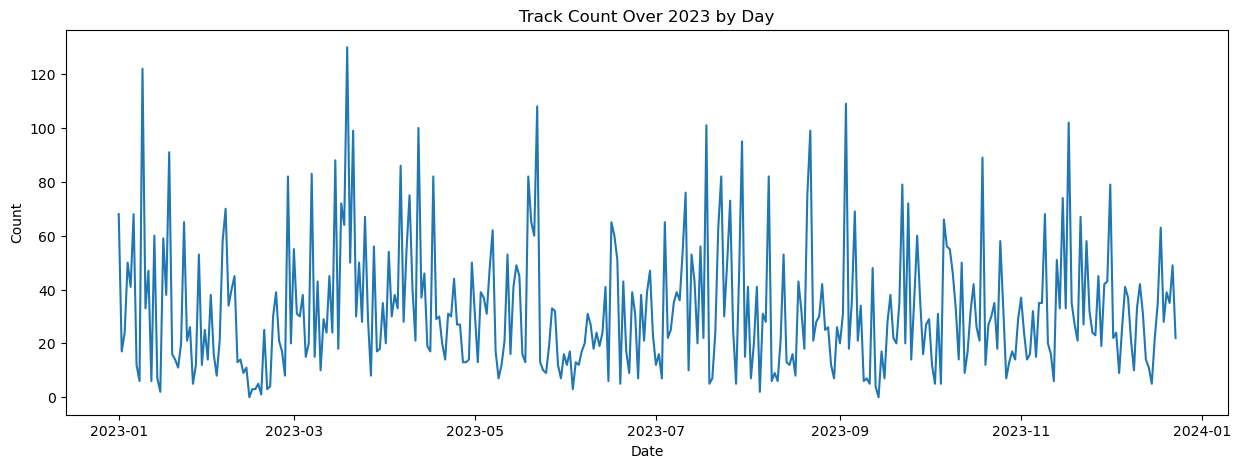

In [37]:
# Line chart for generic daily counts
fig, ax = plt.subplots(figsize=(15,5))
g = sns.lineplot(data=dayLA_count, ax=ax, legend=False)
g.set_title("Track Count Over 2023 by Day")
g.set(xlabel="Date", ylabel="Count")
plt.show()

#### 7.2 Monthly Listening

In [38]:
# Time series of count of scrobbles per month
monthLA_count = us_df.set_index('date_time_usertz') \
    .resample('M')['song'].count() \
    .to_frame().rename(columns={'song':'n_tracks'}) \
    .reset_index()
monthLA_count['month'] = monthLA_count['date_time_usertz'].dt.month

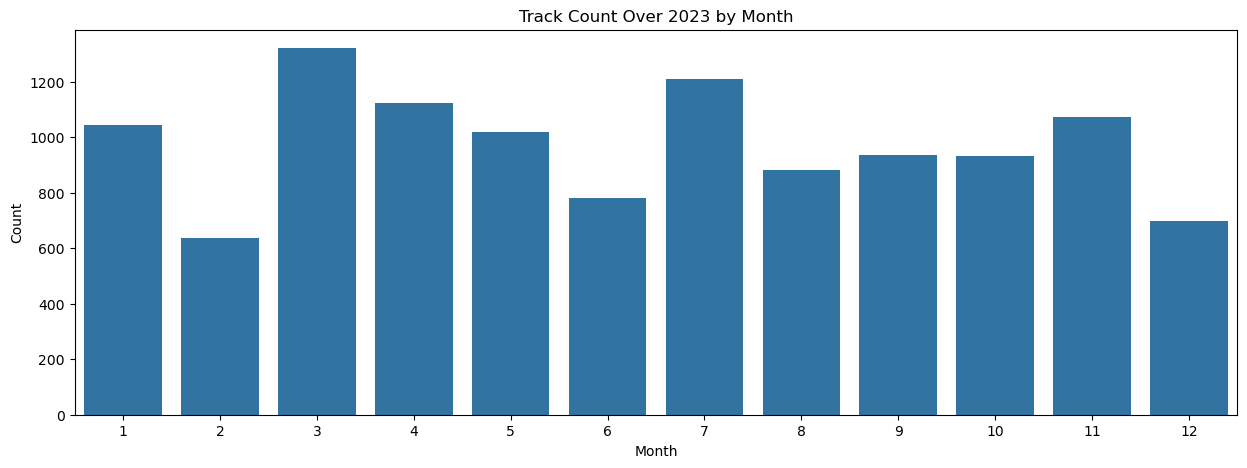

In [39]:
# Line chart for generic monthly counts
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(data=monthLA_count, x='month', y='n_tracks', ax=ax, legend=False)
g.set_title("Track Count Over 2023 by Month")
g.set(xlabel="Month", ylabel="Count")
plt.show()

The month of December has not ended yet, so that might explain why it is much lower than the rest, but it likely will end up locking in somewhere close to that, or it may end up having around the same amount as June. February is the minimum because someone was visiting Synnu for two weeks of that month.

#### 7.3 Weekly Listening

Saturday is usually a day spent socializing or recovering from a work week, so it would make sense that it is the minimum.

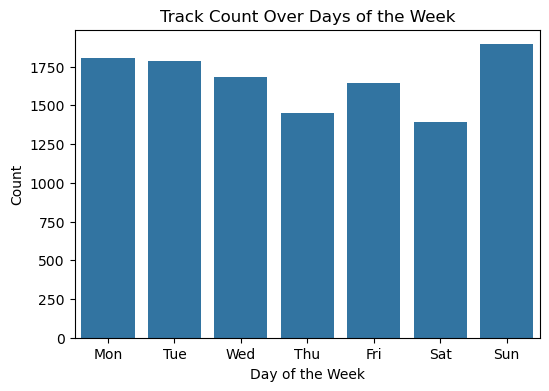

In [40]:
dayLA_count['dow'] = dayLA_count.index.dayofweek
fig, ax = plt.subplots(figsize=(6,4))
g = sns.barplot(dayLA_count.groupby('dow')['n_tracks'].sum())
g.set_title("Track Count Over Days of the Week")
days_strings = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
g.set_xticks(ticks=g.get_xticks(), labels=days_strings)
g.set(xlabel="Day of the Week", ylabel="Count")
plt.show()

#### 7.4 Hourly Listening

##### 7.4.1 Polar Clocks

I had help making the polar bar chart from [here](https://python-graph-gallery.com/circular-barplot-basic/), and the documentation for matplotlib's text is [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html).

In [41]:
def plot_circular_bar_clock(df, x_col, y_col,
                            title,
                            lower_limit=350, label_clockpadding=35,
                            max=0,
                            ax=None):
    """
    This makes bars arranged in a circle. This is best used for a dataset with
    24 categories because it operates under the assumption that it will make a
    clock with 0 (midnight) north.

    df - The DataFrame containing an x_col and y_col column.
    x_col - The 'x-axis' data, which determines the angle.
    y_col - The 'y-axis' data, which determines the length of the bars.
    title - A string for the title of the chart.
    lower_limit - The center whitespace of the chart.
    label_clockpadding - The padding for the x-labels, which will be subtracted
        from the lower_limit, meaning that it will sit inside of the whitespace
        when this value is positive.
    max - This value should be the maximum of the DataFrame, and it is an
        argument in case you make multiple clocks for subplots and want the
        categories to be scaled with the same max. Otherwise, the max of the df
        y_col will be used.
    ax - The axes.

    The default values are tuned for the clock for all scrobbles for Synnu. As a
    general starting point, the clocks turn out pretty decent-looking by using
    the median for the lower_limit and the median divided by 10 for the clock
    padding. However, fine-tuning for aesthetics is advised, especially for the
    lower_limit because the lower_limit determines the whitespace in the middle.
    """
    # The sort is descending because polar plots 'add' in the CCW direction.
    # This could also probably be mended by multiplying the x component by -1
    df = df.sort_values(x_col, ascending=False)
    
    # lower_limit sets bottom of bars (inner edge)
    # Heights: Scale each item value to new coordinates
    if max == 0:
        max = df[y_col].max()
    slope = (max - lower_limit) / max
    heights = slope * df[y_col]
    # Widths: divide 360 by hours, 2 pi / 24 = pi / 6
    width = 2 * np.pi / len(df[x_col])
    # Angles: increment by width
    indices = list(range(0, len(df[x_col])))
    angles = [element * width for element in indices]
    # Polar coordinates start from the east, so spin a bit so 0 is north
    angles = [angle + 7 * width for angle in angles]

    # Draw bars
    bars = ax.bar(x=angles,
                  height=heights, width=width,
                  bottom=lower_limit,
                  linewidth=2,
                  edgecolor="white")

    # Draw labels
    label_fontsize = 9
    label_countpadding = 5
    for bar, angle, height, label, count in zip(bars, angles, heights, df[x_col], df[y_col]):
        # Rotation in degrees
        rotation = np.rad2deg(angle)
        # Flip labels as needed
        alignment = ""
        if (angle >= np.pi / 2) and (angle < 3 * np.pi / 2):
            alignment = "right"
            rotation += 180
        else:
            alignment = "left"
        # Inner clock labels
        ax.text(
            x=angle,
            y=lower_limit - label_clockpadding,
            s=label,
            fontsize=label_fontsize,
            ha='center',
            va='center_baseline'
        )
        # Outer count labels
        ax.text(
            x=angle,
            y=lower_limit + bar.get_height() + label_countpadding,
            s=int(count),
            ha=alignment,
            va='center',
            rotation=rotation,
            rotation_mode='anchor',
            color='tab:blue'
        )
    ax.set_title(title)
    return ax

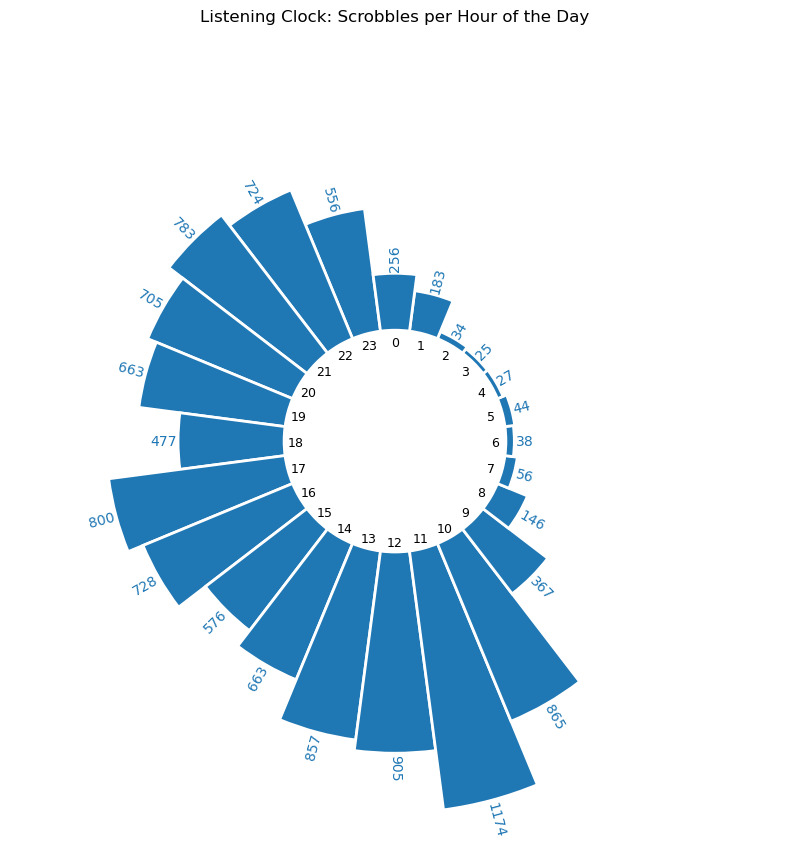

In [42]:
hourly_tracks = us_df.groupby('date_hour')['song'].count().to_frame('n_tracks').sort_index(ascending=False).reset_index()
fig, ax = plt.subplots(1,1, subplot_kw=dict(polar=True), figsize=(15,10))
plt.axis('off')
plot_circular_bar_clock(hourly_tracks,
                        'date_hour', 'n_tracks',
                        "Listening Clock: Scrobbles per Hour of the Day",
                        ax=ax)
plt.show()

Synnu mostly listens to music at 11 AM. There are two relative minima during the day, at about 2-3 PM and 6 PM. However, glancing at this clock, the easiest information to pick up is only that the max is at 11 AM and the minimum is at 3 AM, and also that generally, this user does not listen to music around 2-7 AM. Further information is harder to read, which is a danger of polar bar plots, but this was mostly for fun, and it is cute (to me) that it looks like an actual clock.

In [43]:
hourly_tracks.describe()

,date_hour,n_tracks
count,24.000000,24.000000
mean,11.500000,485.500000
std,7.071068,351.322842
min,0.000000,25.000000
25%,5.750000,123.500000
50%,11.500000,566.000000
75%,17.250000,741.750000
max,23.000000,1174.000000


Using equinoxes and solstices, from the US Naval Observatory [page](https://aa.usno.navy.mil/data/Earth_Seasons), I approximated the seasons.

In [44]:
def get_season_2023(date):
    """
    Returns the season for a given date, using equinoxes and solstices of 2023.

    date - The datetime to determine the season of.
    """
    vernal_equinox = datetime.datetime(year=2023, month=3, day=20, hour=21, minute=24, tzinfo=pytz.timezone('UTC'))
    summer_solstice = datetime.datetime(year=2023, month=6, day=21, hour=14, minute=58, tzinfo=pytz.timezone('UTC'))
    autumnal_equinox = datetime.datetime(year=2023, month=9, day=23, hour=6, minute=50, tzinfo=pytz.timezone('UTC'))
    winter_solstice = datetime.datetime(year=2023, month=12, day=22, hour=3, minute=27, tzinfo=pytz.timezone('UTC'))
    if (date < vernal_equinox) | (date >= winter_solstice):
        return 'Winter'
    elif (date >= vernal_equinox) & (date < summer_solstice):
        return 'Spring'
    elif (date >= summer_solstice) & (date < autumnal_equinox):
        return 'Summer'
    elif (date >= autumnal_equinox) & (date < winter_solstice):
        return 'Autumn'

us_df['season'] = us_df.apply(lambda x: get_season_2023(x['date_time_usertz']), axis=1)

In [45]:
season_hourly_tracks = us_df.groupby(['season', 'date_hour'])['song'].count().to_frame('n_tracks').sort_index(ascending=False).reset_index()

hours_in_a_day = set(range(0,24))
missing_season_hours = []
for season in season_hourly_tracks['season'].unique():
    hours = set(season_hourly_tracks[season_hourly_tracks['season'] == season]['date_hour'].unique())
    if len(hours) != 24:
        missing_hours = list(hours_in_a_day - hours)
        for h in missing_hours:
            missing_season_hours.append({'season': season, 'date_hour': h, 'n_tracks': 0})

season_hourly_tracks = pd.concat([season_hourly_tracks, pd.DataFrame(missing_season_hours)])

In [46]:
season_hourly_tracks.describe()

,date_hour,n_tracks
count,96.000000,96.000000
mean,11.500000,121.375000
std,6.958524,98.911045
min,0.000000,0.000000
25%,5.750000,22.750000
50%,11.500000,117.500000
75%,17.250000,194.000000
max,23.000000,392.000000


As stated before, clocks are silly and fun, but it is difficult to compare the differences.

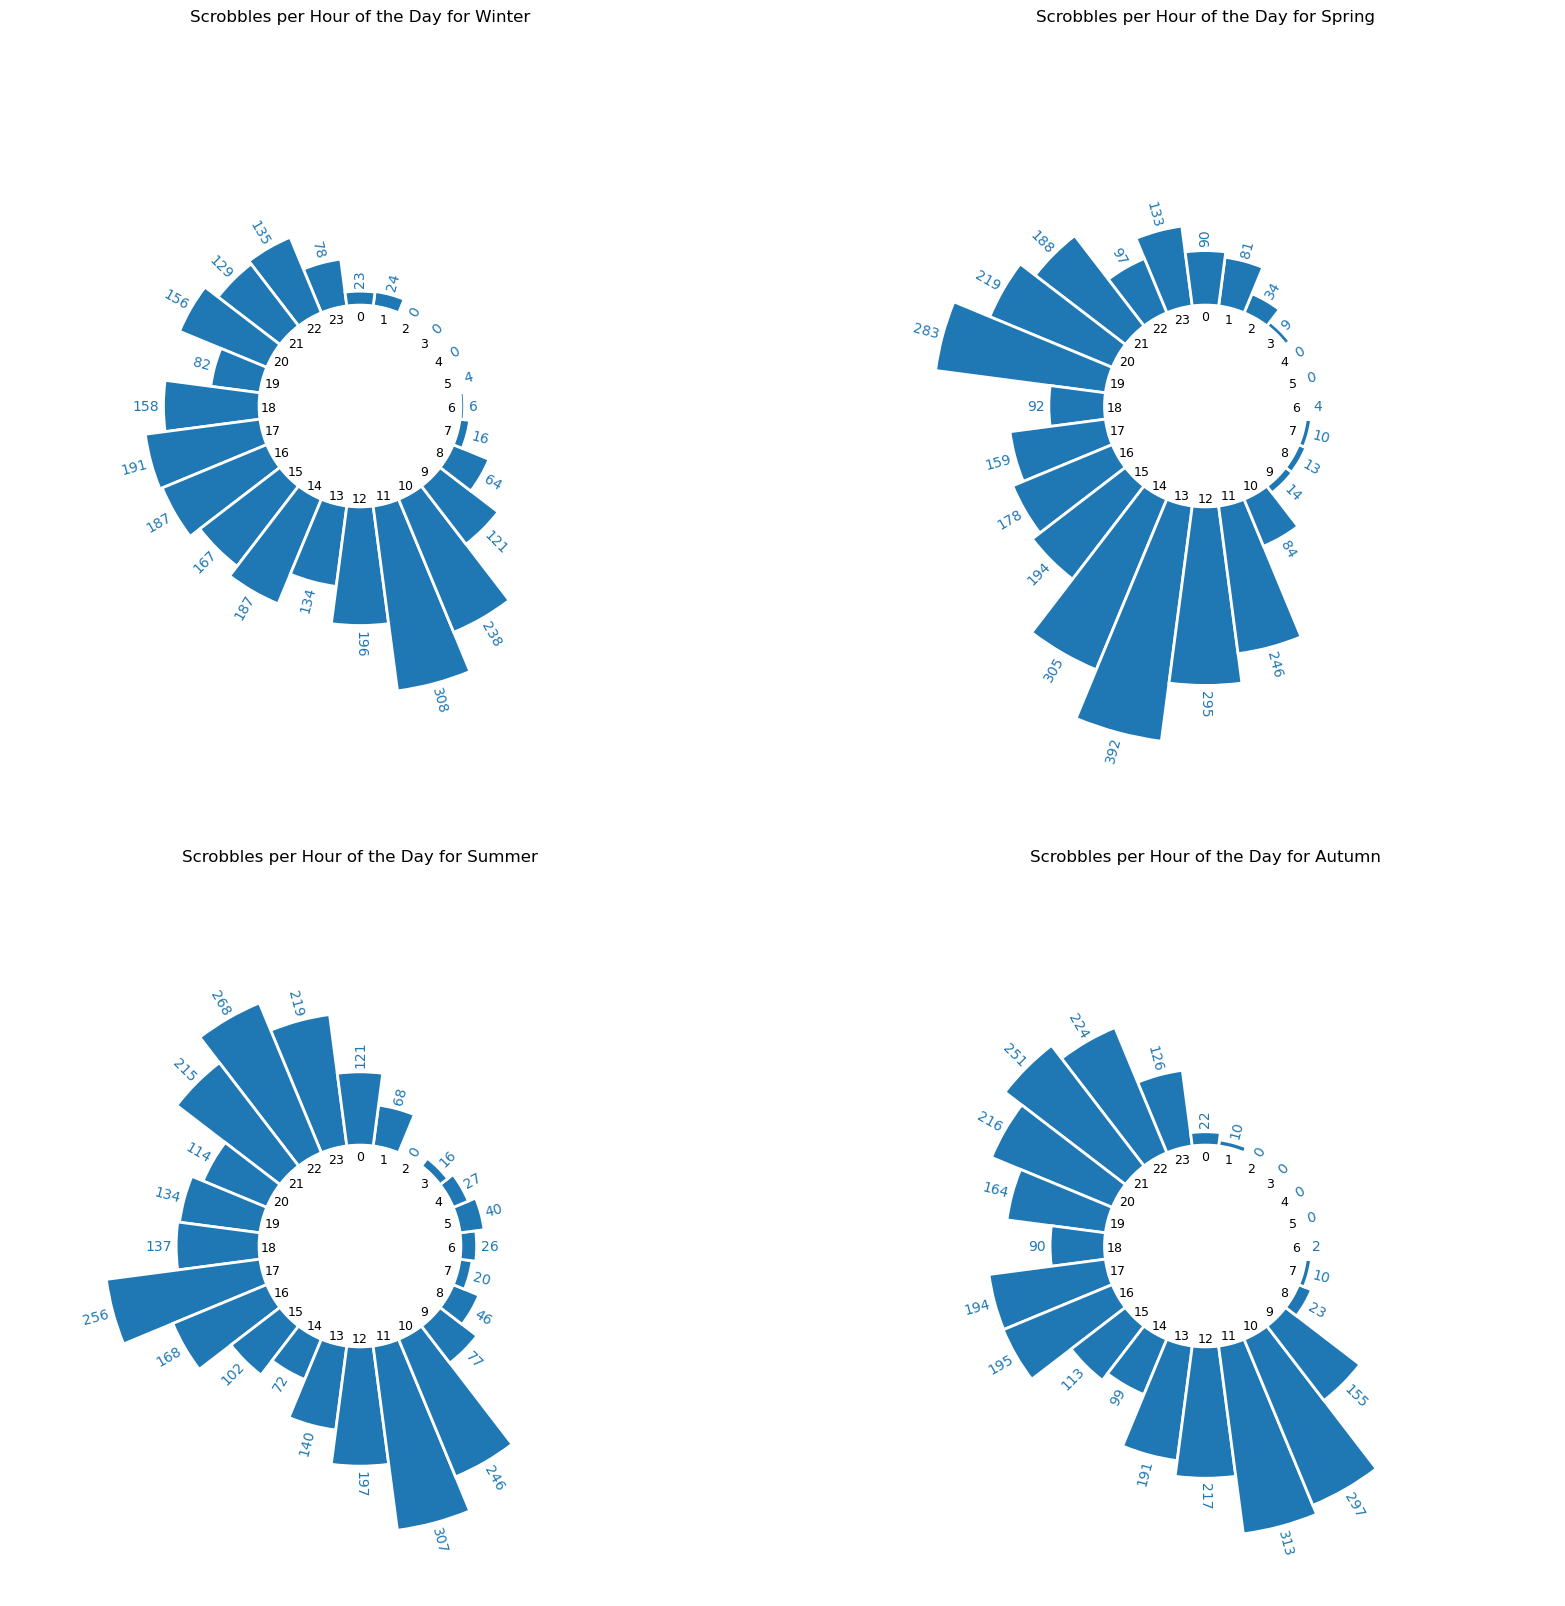

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20), sharey=True,
                        subplot_kw=dict(projection='polar'))
seasons_list = ['Winter', 'Spring', 'Summer', 'Autumn']
n = 0
for i in range(0,2):
    for j in range(0,2):
        plot_circular_bar_clock(season_hourly_tracks[season_hourly_tracks['season'] == seasons_list[n]],
                                'date_hour', 'n_tracks',
                                "Scrobbles per Hour of the Day for " + seasons_list[n],
                                lower_limit=int(season_hourly_tracks['n_tracks'].median()),
                                label_clockpadding=int(season_hourly_tracks['n_tracks'].median())/10,
                                max=season_hourly_tracks['n_tracks'].max(),
                                ax=axs[i][j])
        axs[i][j].axis('off')
        n += 1

plt.show()

##### 7.4.2 Horizontal Clocks

Making a line chart is quicker, and it's easier to notice the patterns and oddballs. It looks like Synnu does not listen to music around 2 AM to 7 AM, which are typically sleeping times. There are unusual spikes in Summer during these hours--most likely because of traveling. What else but tune out external noises at the airport at 4-5 AM with music? The max hour was at 1 PM in Spring. The distributions look like they are probably bimodal.

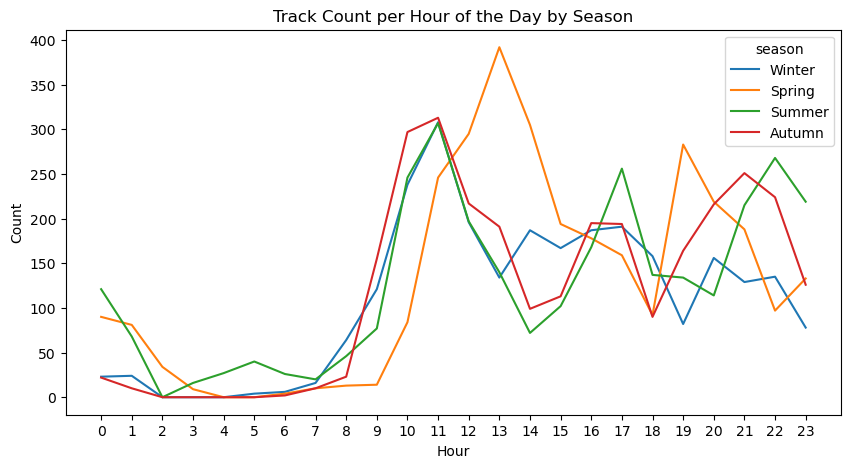

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
g = sns.lineplot(season_hourly_tracks, x='date_hour', y='n_tracks', hue='season', hue_order=['Winter', 'Spring', 'Summer', 'Autumn'])
g.set_title("Track Count per Hour of the Day by Season")
g.set_xticks(range(0,24))
g.set(xlabel="Hour", ylabel="Count")
plt.show()

That the hour of the day is discrete makes it nice as a bar chart as well. Bars help make the shapes of the distributions easier to see, and dividing them into their own plots help find more precise counts too. All of the seasons follow a similar somewhat bimodal distribution. Summer has some anamolous non-zero counts at the typically zero count hours of the late night and early morning. Spring and summer have a slightly larger spread of hours, whereas winter and autumn have little to no scrobbles at 2-5 AM. Is this because Synnu started a new sleep regiment, or is this because the increased amount of sunlight in summer and spring give people more energy at more hours? Two relative minima occur around 2 PM and 6 PM, with the latter likely being caused by dinnertime.

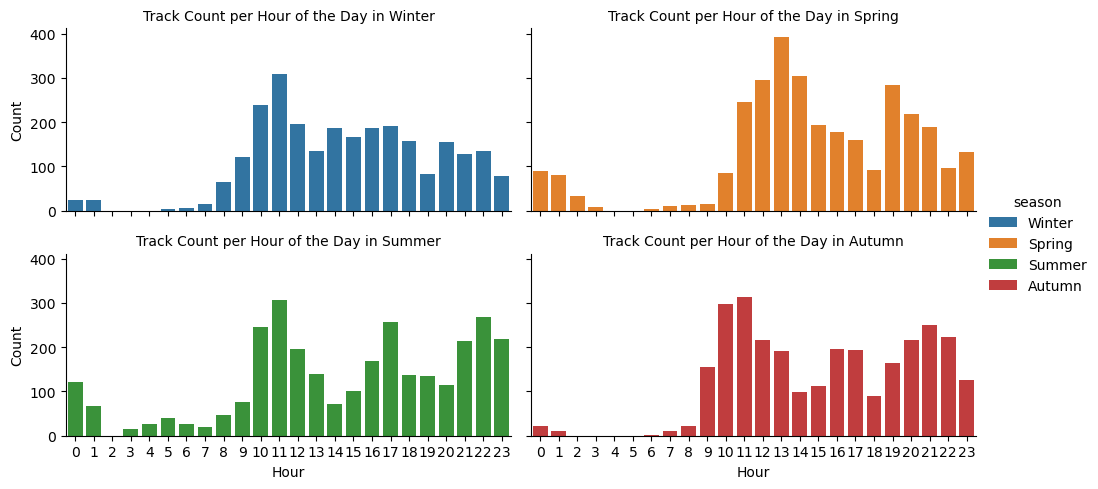

In [49]:
g = sns.catplot(season_hourly_tracks, kind='bar',
                x='date_hour', y='n_tracks', col='season',
                col_order=['Winter', 'Spring', 'Summer', 'Autumn'],
                col_wrap=2,
                hue='season', hue_order=['Winter', 'Spring', 'Summer', 'Autumn'],
                height=2.5, aspect=2)
g.set_titles("Track Count per Hour of the Day in {col_name}")
g.set_axis_labels(x_var="Hour", y_var="Count")
plt.show()

#### 7.5 Charts for Top 5 Artists, Albums, and Tracks

I mostly wanted to test how this all would look. I actually would have preferred to do monthly or seasonal comparisons with something more generic information, like genre, but I ended up not having any more generic data. I wanted to see if Synnu listened to genres in bursts because my assumption was as such, especially since some of my other friends have stated before that they like to listen to certain kinds of music depending on the season or weather.

In [50]:
top5_artists = us_df.groupby('artist_lower').size().to_frame('count').reset_index().sort_values('count', ascending=False)[:5].merge(us_df, how='inner', on='artist_lower')
top5_artists_ts = top5_artists.set_index('date_time_usertz').groupby('artist_lower')['song'].resample('M').count().to_frame('count').reset_index()
top5_artists_ts['artist'] = top5_artists_ts['artist_lower'].str.title()
top5_artists_ts['month'] = top5_artists_ts['date_time_usertz'].dt.month

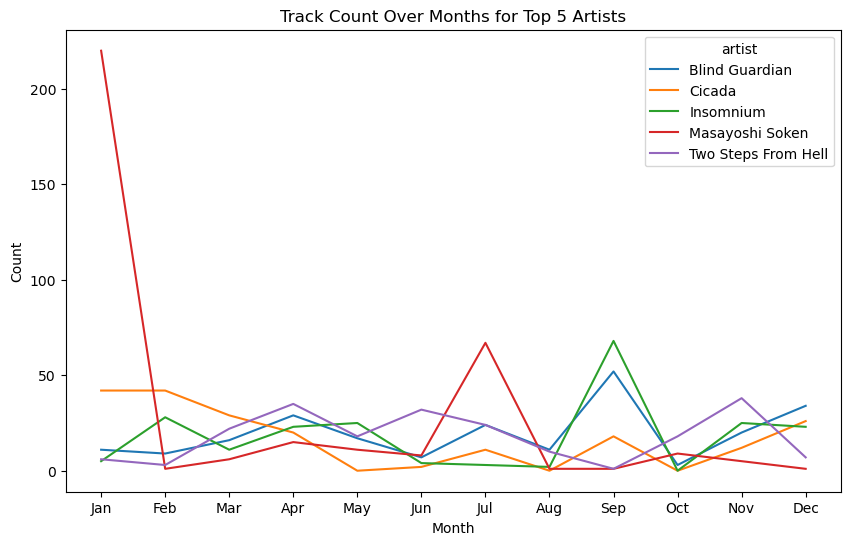

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.lineplot(top5_artists_ts, x='month', y='count', hue='artist')
g.set_title("Track Count Over Months for Top 5 Artists")
months_strings = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
g.set_xticks(ticks=range(1,13), labels=months_strings)
g.set(xlabel="Month", ylabel="Count")
plt.show()

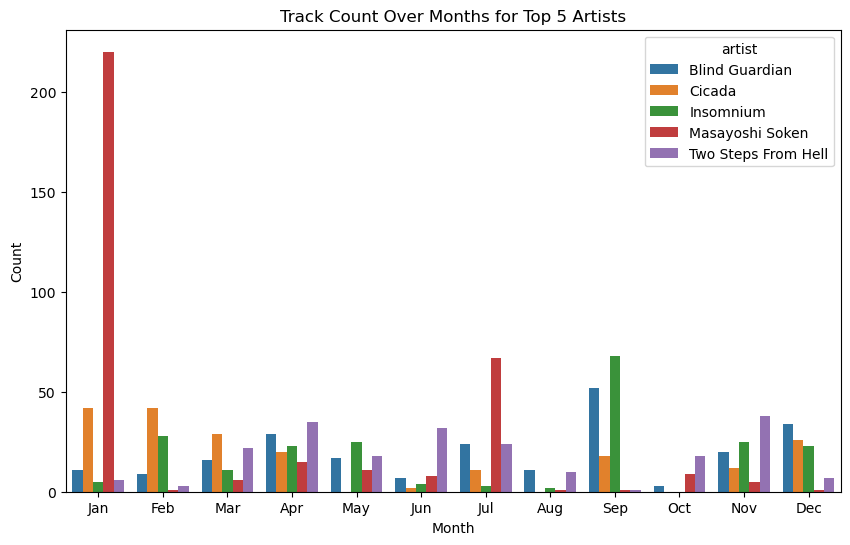

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.barplot(top5_artists_ts, x='month', y='count', hue='artist')
g.set_title("Track Count Over Months for Top 5 Artists")
g.set_xticks(ticks=range(0,12), labels=months_strings)
g.set(xlabel="Month", ylabel="Count")
plt.show()

I don't particularly like how these graphs turned out in general, and the ones for Albums and Tracks are even worse. It isn't as bad with artists because they have at least some appearances throughout the year, and thus you can see at least a little bit of information (and line points) for each of them, but the Albums and Tracks don't have as good continuity. For example, the first scrobble from the album *Icon* was not until some time in the autumn season, and thus it only has data starting from mid-autumn to winter.

## 8 Save Data

In [53]:
# Want artist, song, album, duration, user tz timestamp string, month, hour, day of week, season
us_df['date_dow'] = us_df['date_time_usertz'].dt.day_name()
us_df['date_time_usertz_str'] = us_df['date_time_usertz'].dt.strftime("%Y-%m-%d %H:%M:%S")
usdf_output_file = THIS_USER + "-" + str(THIS_YEAR) + "_out.xlsx"
us_df[['artist', 'song', 'album', 'song_length', 'date_time_usertz_str', 'date_month', 'date_hour', 'date_dow', 'season']].to_excel(usdf_output_file)

## 9 Conclusion

To reiterate, the purpose of this project was mostly for fun and was caused by a slight envy of many of my friends sharing and comparing their Spotify wrapped, whereas I had nothing interesting to show. I also wanted to use this data to start learning Tableau, so to compare, the dashboard story is [here](https://public.tableau.com/app/profile/rachel.c1809/viz/L_fmFun-Syn2023/Report).

Reviewing above... (And I am not going to be updating this written conclusion, though I may update my profile.)

Top artists by count
| Artist | Count |
| --- | --- |
| Masayoshi Soken | 345 |
| Blind Guardian | 233 |
| Insomnium | 217 |
| Two Steps from Hell | 214 |
| Cicada | 202 |

Top artists by seconds listened
| Artist | Seconds |
| --- | --- |
| Masayoshi Soken | 92964 |
| Be'lakor | 86511 |
| Blind Guardian | 78059 |
| Swallow the Sun | 76668 |
| Insomnium | 75565 |

Top albums by count
| ***Album*** - Artist | Count |
| --- | --- |
| ***棲​居​在​溪​源​之​上 Seeking the Sources of Streams*** - Cicada | 154 |
| ***Final Fantasy Crystal Chronicles Original Soundtrack*** - 谷岡久美 | 115 |
| ***Icon*** - Paradise Lost | 109 |
| ***Undertale Soundtrack*** - Toby Fox | 105 |
| ***SHADOWBRINGERS: Final Fantasy XIV Original Soundtrack*** - Masayoshi Soken | 99 |

Top albums by seconds listened
| ***Album*** - Artist | Seconds |
| --- | --- |
| ***棲​居​在​溪​源​之​上 Seeking the Sources of Streams*** - Cicada | 46569 |
| ***Songs from the North I, II & III*** - Swallow the Sun | 31582 |
| ***Anno 1696*** - Insomnium | 29716 |
| ***Stone's Reach*** - Be'lakor | 28117 |
| ***Icon*** - Paradise Lost | 26809 |

Top tracks by count
| **Track** - Artist | Count |
| --- | --- |
| **巨木曾在的痕跡 Remains of Ancient Trees** - Cicada | 32 |
| **雨從傍晚下到午夜 Raining on the Tent** - Cicada | 28 |
| **What You Love (feat. Wansun Kim)** - DIDI HAN | 25 |
| **Imaginations from the Other Side** - Blind Guardian | 18 |
| **松葉上的鳥與水珠 Birds and Moist Pine Needles** - Cicada | 16 |

Top tracks by seconds listened
| **Track** - Artist | Seconds |
| --- | --- |
| **巨木曾在的痕跡 Remains of Ancient Trees** - Cicada | 18403 |
| **棲居在溪源之上 Seeking the Sources of Streams** - Cicada | 10185 |
| **Imaginations from the Other Side** - Blind Guardian | 9164 |
| **The 6ixth Session Disc 1** - Dieselboy | 7689 |
| **Perlence Subrange 6-36** - Autechre | 7031 |

Small Stats
| Description | Amount |
| --- | --- |
| Total tracks scrobbled | 11,652 |
| Total seconds listened | 2,935,972 |
| Total time listened | 33 days, 23\:32\:52 |
| Percent of year spent with music | 9.31% |
| Average track length | 255.22 sec |
| Average track length | 4 min 15 sec |
| Average scrobbles per day | 33 |
| Average scrobbles per month | 971 |
| Longest consecutive days listening (streak) | 211 |

Some patterns could be seen in the charts.

February and December have the fewest scrobbles, but December may be low because it has not ended yet, but it will likely end up around the count that it is at because there are only 7 days left of December. February had an unusually low count because someone was visiting the user (me) for two weeks during that month.

Saturday had the fewest scrobbles, which is probably because Saturday is a day spent socializing, particularly with family, so that means there is less time for music.

The highest number of scrobbles in an hour was at 11 AM. There are also two relative minima during the day, at about 2-3 PM and at 6 PM. The latter could be explained by dinnertime. Generally, Synnu does not listen at late night and early morning hours (2-7 AM). Spring and summertime have a slightly larger spread of hours, entering the typically zero-scrobble hours of the late night and early morning, whereas winter and autumn have little to no scrobbles at 2-5 AM.



Extra note: For whatever reason, the rendering on Jupyter Notebook has been spontaneously obliterating my text inputs, so I apologize if there are random missing words or segments.